# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 24/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))


In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    # delete the first row
    df = df.drop(0)
    # set the header and drop the row
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    # Check for duplicate column names
    duplicate_cols = df.columns[df.columns.duplicated()]
    # print(duplicate_cols) 

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        df = df.drop(df.columns[0], axis=1)
        # Concat
        df_batters = pd.concat([df_batters, df])
        # Move
        shutil.move(file, destination_folder_batters)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [16:51<00:00, 101.17s/it]


In [7]:
# Store unaggregated data between sessions in parquet file
df_pitchers.to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

## Data Types

### Pitchers

In [8]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [9]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [10]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [11]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [12]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'Lev': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BABIP vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BABIP vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [13]:
df_batters['GS'].fillna('0', inplace=True)
df_batters['G'].replace({None: '0'}, inplace=True)

In [14]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [15]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

## Aggregations

### Pitcher aggregations

In [16]:
# # too slow
# wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

# %%time
# pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [17]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if item != 'IP':
                ip9_list.append(item)

In [18]:

# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.copy()


df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()

# Reset index
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

In [19]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

# Reset index
df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['IP'] = df_pitchers_agg_IP

### Batter aggregations

In [20]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO']
wm_def_col = ['PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I', 'FRM', 'ARM']

wm_col = []

for item in df_batters[df_batters.iloc[:, 53:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
#             if (item != 'PA') & ( item != 'IP'):
                wm_col.append(item)


In [21]:
# Aggregation per player and team
df_batters_agg_team = df_batters.copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :53].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA'], axis=0).mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP'], axis=0).mul(1000, axis=0)

In [22]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()

# Reset index
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA'], axis=0).mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP'], axis=0).mul(1000, axis=0)


### Team aggregations

In [23]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['W','L','HR','R', 'ER', 'BB', 'K']].sum().copy()

# Rename columns
df_team_agg = df_team_agg.rename(columns={'HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA'})

# Calculate winning rate
df_team_agg['WRATE'] = df_team_agg['W']/(df_team_agg['W']+df_team_agg['L'])

# Merge with batters' data by team
df_team_agg = df_team_agg.merge( df_batters.groupby('ORG')[['H','HR', 'R', 'BB']].sum().reset_index(), on='ORG', how='left')

# Filter teams with more than 10 wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 40].sort_values('WRATE', ascending=False)

,ORG,W,L,HRA,RA,ERA,BBA,K,WRATE,H,HR,R,BB
560,Vancouver Vibes TBD,73,38,111,411,380,455,845,0.657658,1017,106,586,539
185,Felix Antkillers,44,23,76,267,253,264,529,0.656716,571,95,342,310
160,Ditmas Park Tip-Tops,55,32,76,395,379,380,729,0.632184,841,117,510,449
403,Perth Pantheon,48,28,65,304,290,299,536,0.631579,547,86,347,372
184,Fayetteville Firestorm,41,25,96,324,308,275,542,0.621212,601,68,381,352
206,Goyang Cats,44,30,87,349,323,292,601,0.594595,613,119,395,362
211,Great Lakes Squirrels,50,35,104,354,337,322,638,0.588235,665,57,383,432
304,Madrid Real,45,34,79,318,312,461,748,0.56962,651,103,411,447
191,Fogtown Stars,292,234,623,2439,2325,1991,3965,0.555133,4675,609,2560,2322
330,Milkyway Dream,60,49,120,475,459,499,949,0.550459,1002,126,558,484


# Analysis

## My team comparison

### Batting

In [24]:
df_batters_agg_team[df_batters_agg_team['ORG'] == 'Fogtown Stars'].sort_values('WAR', ascending=False)

,POS,Name,ORG,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,BBT,GBT,FBT,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM
4795,CF,Gorman Thomas,Fogtown Stars,TRN,"6' 2""",Right,Right,61,47,59,62,109,90,31,48,64,66,117,91,33,47,58,60,107,90,30,27,7,Flyball,Ex. Pull,Normal,0,0,10,3,10,8,71,63,51,52,0,0,0,0,0,0,0,52,0,34,55,68,241.98895,116.022099,11.3125,493.922652,159.116022,72.928177,21.546961,0.0,64.640884,145.856354,135.911602,106.077348,15.625,0.0,0.0,0.0,0.0,0.0,134.254144,21.871875,21.546961,86.187845,374.585635,0.3315,0.437281,0.80175,3.14375,14.121875,0.470219,0.513406,1.239187,245.0625,0.314844,9.58011,119.337017,249.40625,87.016575,11.933702,4.467812,0.0,0.0,0.0,87.016575,0.0,10.607735,10.607735,62.983425,0.0,39.779006,0.0,39.779006,0.0,0.0,0.0,0.375,1.6875,-0.1875,0.252375,0.0,0.0,0.0,2.15625,0.0,0.0,0.0,37.5,265.010352,265.010352,37.5,265.010352,265.010352,0.0,265.010352,0.0,0.0,0.0,0.0,0.0,265.010352,0.0,0.0,0.0,53.00207,100.0,32,7.0
6625,RF,Casey Stengel,Fogtown Stars,TRN,"5' 11""",Left,Left,69,87,73,46,48,76,43,84,68,42,44,70,41,88,74,47,49,77,43,43,41,Groundball,Normal,Normal,0,0,6,8,5,1,48,74,58,49,0,0,0,0,0,0,0,0,49,63,67,70,181.469649,147.603834,17.716981,530.990415,169.329073,125.878594,32.587859,0.0,10.86262,89.456869,66.453674,58.146965,9.449057,0.0,0.0,0.0,10.86262,0.0,135.463259,22.639623,0.0,43.450479,234.504792,0.312642,0.377377,0.433887,2.816981,7.218868,0.121245,0.358264,0.811623,129.0,0.404491,7.303514,67.731629,132.150943,22.236422,3.386581,3.848302,10.86262,10.86262,32.075472,22.236422,-2.172524,5.686901,3.514377,12.140575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.716981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,53,2.0
7901,SS,Jody Reed,Fogtown Stars,TRN,"5' 9""",Right,Right,69,63,66,87,14,87,87,64,69,94,15,88,94,63,65,85,14,87,85,51,22,Line Drive,Pull,Normal,0,0,82,69,77,75,3,5,8,73,0,0,0,88,0,73,0,0,0,33,55,58,182.623931,147.356488,29.552284,509.986602,144.986087,85.416881,52.870246,4.926311,1.772648,58.538596,87.251366,75.316912,12.290457,1.442853,5.029372,2.102443,6.946305,0.618365,65.691023,11.683553,22.632176,59.569205,213.026899,0.256662,0.349737,0.373048,4.310863,6.584975,0.116258,0.32986,0.722748,91.431472,0.287575,1.309904,74.884056,91.368528,8.819953,3.368031,4.139909,0.556529,0.700814,2.741117,8.819953,-0.06802,3.819437,3.635989,166.793775,147.356488,559.084819,344.553231,205.091209,9.440379,91.579924,0.0,0.983306,3.987046,0.003655,1.039827,0.0,0.0,0.0,65.115533,0.0,0.0,0.0,89.135127,166.323945,154.839665,56.263249,34.371666,21.356056,33.413198,43.01549,16.289462,15.935939,39.967278,7.583725,19.207817,35.008688,7.07741,47.398971,0.0,0.0,97.404061,985,2232.4
69,1B,Eddie Murray,Fogtown Stars,TRN,"6' 2""",Switch,Right,67,67,81,55,76,53,69,56,60,59,51,35,64,71,88,53,84,59,70,5,2,Flyball,Ex. Pull,Spray,0,0,40,37,38,38,1,3,2,68,0,0,68,0,0,0,0,0,0,20,61,39,161.268885,127.474614,34.025281,528.163956,164.600017,108.651862,23.577974,1.49839,30.871791,116.812515,90.225378,62.659952,10.250281,0.80492,2.179477,0.0,6.996615,0.0,92.726822,15.798525,19.355238,55.948155,283.790143,0.297444,0.368612,0.49502,6.344031,8.281742,0.197639,0.380963,0.863747,125.241573,0.314526,4.433997,96.157021,125.544242,29.793197,3.28779,3.680737,0.0,0.0,0.0,29.793197,0.0,-2.555932,-2.555932,8.507389,0.0,10.018162,0.0,10.018162,0.0,0.866837,0.0,0.304073,2.673265,0.000702,0.047887,0.0,0.0,0.0,0.755688,0.0,0.0,0.0,4.143258,718.82805,

### Catching

In [25]:
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['POS'] == 'C')][['Name','C ABI','C ARM','CERA']].sort_values('CERA', ascending=True)

,Name,C ABI,C ARM,CERA
3723,Ernie Whitt,67,57,4.344024
4110,Ozzie Virgil,66,53,4.569693


### Pitching

#### Starters

In [26]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].sort_values('ERA', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
4566,SP,Alex Wood,Fogtown Stars,Right,Left,66,74,58,72,49,61,86,69,76,57,73,70,55,71,46,57,0,0,0,77,74,0,0,0,63,0,0,0,3,NEU,92,3/4,Normal,70,76,40,41,44,86,1.676113,1.676113,0.473684,0.65587,0.502333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.000000,39.497976,35.125506,9.728745,6.340081,1.712551,0.182186,1.493927,16.287449,5.793522,5.502024,3.753036,0.0,8.271255,0.291498,4.513117,0.270073,0.343124,0.451723,0.794773,0.313745,1.497854,2.834683,20.960729,9.408502,11.567476,0.182186,0.145749,0.510121,0.036437,0.0,0.728745,0.0,0.0,0.0,0.0,0.0,71.608232,0.980877,0.0,0.582996,0.406746,0.0,0.0,0.0,96.940621,10.469636,3.099325,321.651822,15.596491,19.717949,0.462429,1.448043,0.589744,4.72691,102.526316,-0.138462,0.112955,0.065587,3.985587,0.838057,0.692308,0.109312,0.036437,0.0,0.0,0.847503,0.801552,-0.135628,0.567192
6356,SP,Jumbo Elliott,Fogtown Stars,Right,Left,69,76,74,61,64,73,74,73,61,63,71,76,75,61,65,74,73,71,84,0,0,0,0,0,0,0,0,0,3,FB,90,3/4,Normal,76,55,20,19,19,43,1.639162,1.639162,0.554083,0.54254,0.521653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,779.666667,38.86661,34.156905,8.77298,5.413852,1.823856,0.184694,1.350577,15.017956,5.136811,4.732792,4.028645,0.0,8.299701,0.138521,5.424126,0.251979,0.329174,0.430876,0.760046,0.292725,1.422959,2.50047,21.503549,10.231253,11.261693,0.150064,0.392475,0.265498,0.03463,0.0,0.750321,0.0,0.0,0.0,0.0,0.0,72.493288,1.02549,0.0,0.692604,0.477391,0.011543,0.007696,0.0,98.910646,10.300556,3.529842,271.900812,13.076101,16.48012,0.449919,1.046174,0.885421,4.529324,98.96708,-0.078495,0.138521,0.120051,4.021937,0.727234,0.380932,0.300128,0.046174,0.023087,0.0,0.589354,0.680291,-0.029585,0.327183
6035,SP,Johnny Antonelli,Fogtown Stars,Left,Left,69,86,68,51,67,67,85,68,51,66,66,86,69,51,67,67,80,0,87,49,0,0,0,0,0,69,0,0,4,NEU,92,3/4,Normal,74,77,29,24,26,62,1.570505,1.570505,0.60282,0.412456,0.510998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,567.333333,38.675676,33.646886,8.391892,5.409518,1.713278,0.190364,1.078731,13.722092,4.219741,4.108696,4.60047,0.0,8.867803,0.174501,5.560382,0.241803,0.332614,0.395381,0.727978,0.298373,1.44218,2.590306,23.160223,11.632197,11.51745,0.111046,0.142773,0.396592,0.031727,0.0,0.90423,0.0,0.0,0.0,0.0,0.0,79.652115,1.076898,0.0,0.777321,0.563655,0.0,0.0,0.0,102.792597,8.381316,3.338484,220.589307,10.268508,12.824324,0.444859,0.692714,0.688602,4.200235,91.918919,0.0,0.182432,0.223678,3.933831,0.983549,0.618684,0.269683,0.095182,0.047591,0.0,0.579307,0.88839,0.002761,0.387405
5873,SP,Jimmy Key,Fogtown Stars,Right,Left,65,49,71,79,89,64,50,73,73,90,65,49,71,80,88,64,49,35,61,39,0,0,0,0,0,0,0,0,4,NEU,90,3/4,Finesse,84,79,29,26,28,64,1.51083,1.51083,0.572653,0.41426,0.561436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738.666667,37.990072,34.529783,8.784747,5.799639,1.632671,0.097473,1.254964,14.377256,4.544675,4.20352,2.875451,0.0,5.348827,0.182762,5.654282,0.24756,0.304451,0.405146,0.709684,0.259194,1.295465,2.194224,14.329783,7.40194,6.932401,0.097473,0.304603,0.158394,0.024368,0.0,0.68231,0.0,0.0,0.0,0.0,0.0,75.44111,0.973141,0.0,0.877256,0.651327,0.048736,0.040614,0.0,99.909296,8.254061,3.716381,224.661552,14.590253,16.81769,0.470045,0.800993,0.700812,4.660023,102.041968,-0.035334,0.121841,0.191291,4.741891,0.950361,0.633574,0.255866,0.060921,0.024368,0.0,0.671345,0.888822,-0.025857,0.53662
6888,SP,Martin Perez,Fogtown Stars,Left,Left,61,52,76,59,48,79,55,82,61,51,83,50,74,59,47,78,48,0,31,35,61,0,53,0,34,0,0,0,6,GB,93,3/4,GB'er,80,76,20,18,54,50,1.674419,1.674419,0.460465,0.544186,0.524992,0

#### Relievers

In [27]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'].isin(['RP','CL']))].sort_values('ERA', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
934,RP,Alex Cobb,Fogtown Stars,Right,Right,69,62,86,58,63,86,60,84,58,61,83,63,89,59,65,88,47,0,55,0,72,66,0,0,0,0,0,0,4,GB,91,Normal (3/4),GB'er,64,55,35,25,30,71,7.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.928571,0.0,0.0,4.666667,36.642857,30.857143,3.857143,1.928571,1.928571,0.0,0.0,5.785714,0.0,0.0,5.785714,0.0,9.642857,0.0,0.0,0.120929,0.2525,0.180214,0.432714,0.175,1.071429,0.964286,26.892857,13.928571,12.964286,0.0,0.0,0.0,0.0,0.0,0.0,7.714286,3.857143,0.0,0.0,0.0,100.0,0.467143,0.392857,0.0,0.0,0.0,0.0,0.0,17.214286,0.0,0.0,20.428571,1.785714,1.428571,0.560714,0.0,0.0,2.264286,54.571429,0.192857,0.385714,0.578571,3.9,1.928571,1.928571,0.0,0.0,0.0,0.0,0.357143,1.928571,0.035714,0.358214
1198,RP,Bob Walk,Fogtown Stars,Right,Right,69,35,107,57,81,102,32,98,55,77,98,37,115,58,85,106,0,14,39,32,63,0,0,0,0,0,0,0,4,GB,90,Normal (3/4),GB'er,74,55,28,22,26,59,4.05,0.0,2.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,6.666667,37.8,33.75,6.75,6.75,0.0,0.0,0.0,6.75,0.0,0.0,4.05,0.0,4.05,0.0,0.0,0.2,0.27905,0.2,0.47905,0.22785,1.1965,1.475,11.03,9.875,1.125,0.0,0.0,1.35,0.0,0.0,0.0,4.05,0.0,4.05,0.0,0.0,100.0,0.539,0.0,0.0,0.0,0.0,0.0,0.0,33.7,0.0,0.0,50.6,5.6,3.0,0.63,0.0,0.65,3.0535,73.35,0.27,0.135,0.54,5.6175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195,0.0
2663,RP,Jon Garland,Fogtown Stars,Right,Right,69,47,76,83,77,72,47,76,83,76,71,47,77,83,78,73,0,35,47,30,61,38,39,0,0,0,0,0,6,NEU,90,Over the Top,Finesse,65,105,39,30,37,80,2.842105,0.0,0.0,0.0,0.0,2.842105,1.421053,0.473684,0.0,0.0,0.0,1.421053,0.0,6.333333,32.684211,27.0,1.421053,1.421053,0.0,0.0,0.0,1.421053,0.0,0.0,5.684211,0.0,8.526316,0.0,0.0,0.047895,0.216316,0.047895,0.264211,0.065789,0.791053,1.5,26.368421,17.578947,8.789474,0.0,0.0,0.0,0.0,0.0,1.421053,2.842105,1.421053,2.842105,0.0,0.0,100.0,0.526842,0.473684,0.0,0.0,0.0,0.0,0.0,48.736842,0.0,0.0,48.736842,3.526316,2.526316,0.584211,0.0,0.0,2.563684,61.684211,0.142105,0.284211,0.568421,4.267895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105263,0.0
2903,RP,Kevin Slowey,Fogtown Stars,Right,Right,69,59,47,98,57,48,57,46,97,55,47,60,48,99,58,49,46,67,43,44,61,0,0,0,0,0,0,0,5,EX FB,90,Over the Top,Finesse,63,70,27,27,25,61,4.5,0.0,0.5,0.0,0.425926,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.000000,32.5,31.5,5.0,2.5,1.0,0.0,1.5,10.5,2.5,2.5,1.0,0.0,6.5,0.0,3.9,0.157019,0.182333,0.329796,0.51213,0.146574,0.665741,2.037037,20.081481,3.025926,17.055556,0.0,0.0,0.5,0.0,0.0,0.0,4.5,1.5,1.5,0.0,0.0,78.703704,0.473704,0.316463,0.0,0.0,0.0,0.0,0.0,27.574074,0.0,0.0,83.611111,5.314815,8.611111,0.397963,0.0,0.259259,3.54463,89.648148,0.25,0.1,0.2,3.152037,0.5,0.0,0.5,0.0,0.0,0.0,0.314815,0.500556,0.077778,0.0
3259,RP,Melido Perez,Fogtown Stars,Right,Right,69,83,73,48,61,73,79,70,47,59,70,87,77,49,64,77,81,0,0,69,0,0,0,78,0,0,0,0,3,NEU,92,Over the Top,Normal,83,58,27,21,23,55,9.0,0.0,1.125,1.125,0.25,7.875,6.75,0.875,1.125,0.125,0.0,5.625,1.125,8.000000,33.75,29.25,4.5,3.375,0.0,0.0,1.125,7.875,2.25,2.25,4.5,0.0,12.375,0.0,5.0625,0.1395,0.2585,0.255,0.513,0.2,1.0,2.75,35.85,13.6,22.2,0.0,0.0,0.0,0.0,0.0,2.25,9.0,9.0,0.0,0.0,0.0,88.45,1.6075,1.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,54.75,1.5,2.25,0.395,0.0,0.0,2.86,70.25,0.0,0.1125,0.225,2.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3976,RP,Storm Davis,Fogtown Stars,Right,Right,68,63,79,60,71,77,63,79,60,71,76,63,79,60,72,77,71,61,0,0,0,0,0,71,0,0,0,0,3,NEU,91,Normal (3/4),Normal,72,66,26,25,23,57,4.973684,0.0,0.0,0.0,0.0,1.421053,0.710526,0.421053,0.0,0.0,0.0,0.0,0.710526,12.666667,40.5,34.815789,9.236

## Player analytics

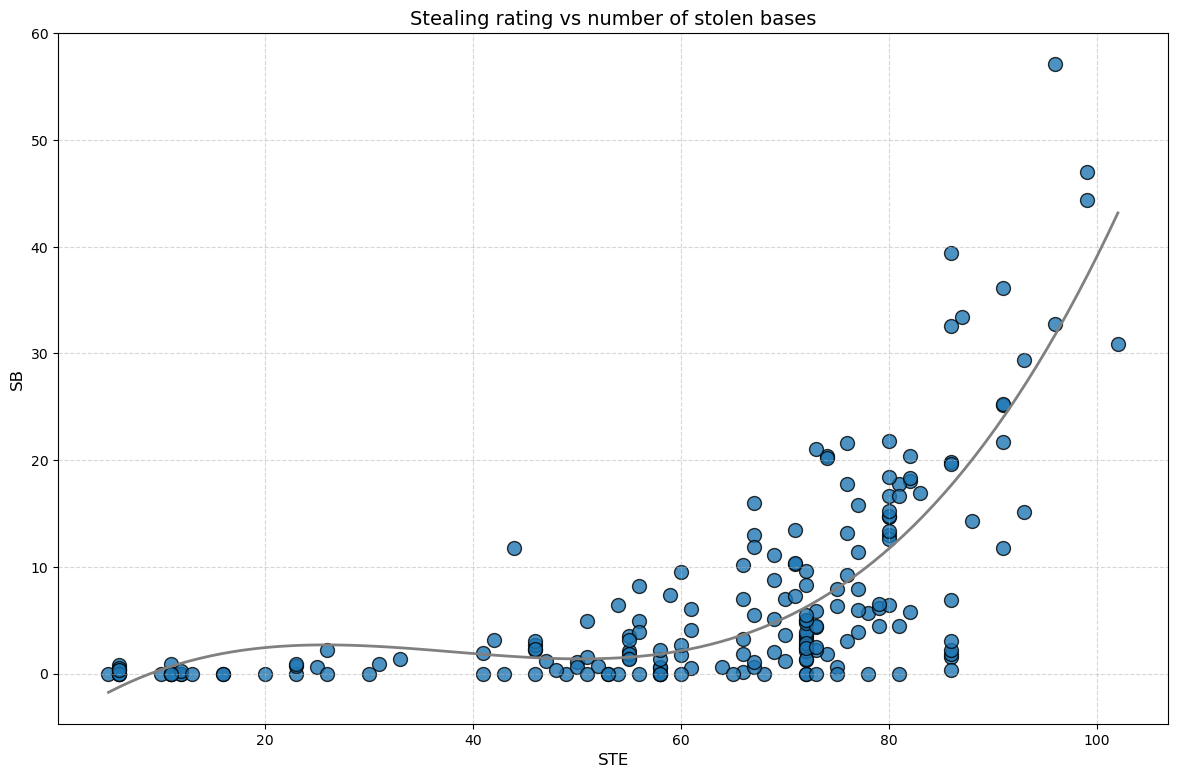

In [28]:
# Stolen bases

# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR # not excluding anything but good to have it for completness
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 3)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Show the plot
plt.show()


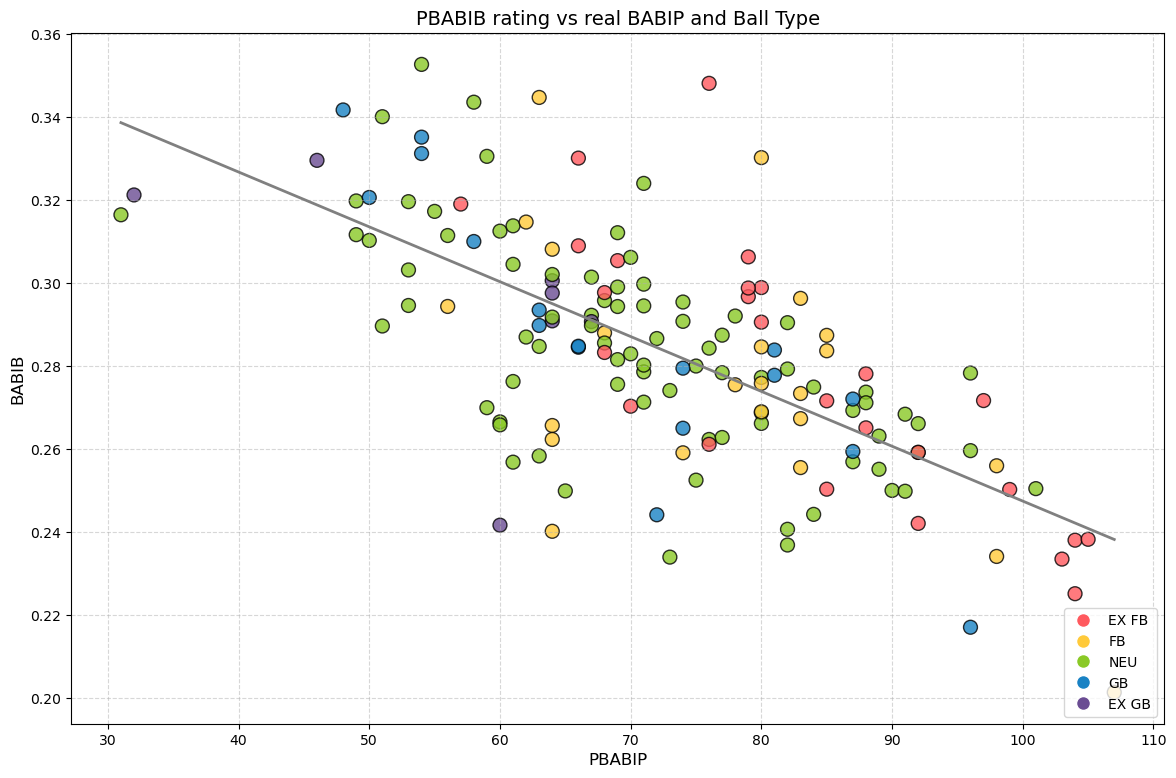

In [29]:
# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}
chart_data = df_pitchers_agg[df_pitchers_agg['IP'] > 100]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(chart_data['PBABIP'], chart_data['BABIP'], s=100, c=chart_data['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# # Calculate polynomial fit
# coefficients = np.polyfit(chart_data['BABIP'].astype(float), chart_data['PBABIP'].astype(float), 1)
# polynomial = np.poly1d(coefficients)
# x_values = np.linspace(min(chart_data['BABIP']), max(chart_data['BABIP']), 100)
# y_values = polynomial(x_values)

# from sklearn.linear_model import Ridge

# # Fit a ridge regression model
# ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter
# ridge.fit(np.vander(np.nan_to_num(chart_data['BABIP'], nan=0.0), 3), np.nan_to_num(chart_data['PBABIP'], nan=0.0))

# # Generate predicted values using the ridge model
# y_values = ridge.predict(np.vander(x_values, 3))

# Fit linear regression
X = sm.add_constant(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(chart_data['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

# Generate the linear regression line
x_values = np.linspace(min(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

# Show the plot
plt.show()


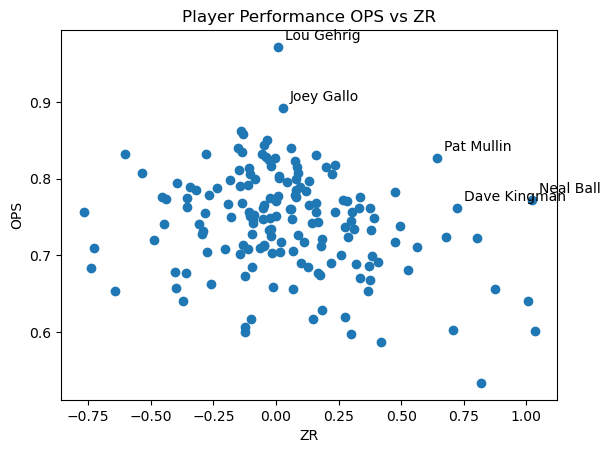

In [30]:
# Standardization
def standardize(column):
    mean = np.mean(column)
    std = np.std(column)
    standardized_column = (column - mean) / std
    return standardized_column
# Normalization
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(val - min_val) / (max_val - min_val) for val in column]
    return normalized_column

data = df_batters_agg[df_batters_agg['PA_WM'] > 300]

# Separate data into x and y coordinates
x = data['ZR']
y = data['OPS']
names = data['Name']


# Create scatter plot
plt.scatter(x, y)

# Find the indices of the top 5 records in the right-top quadrant
top_records_indices = sorted(range(len(x)), key=lambda i: (standardize(x).iloc[i] + standardize(y).iloc[i]))[-5:]

# Add names to the top records
for index in top_records_indices:
    plt.annotate(names.iloc[index], (x.iloc[index], y.iloc[index]), xytext=(5, 5), textcoords='offset points')

# Set labels and title
plt.xlabel('ZR')
plt.ylabel('OPS')
plt.title('Player Performance OPS vs ZR')

# Display the chart
plt.show()


## Modeling

### Batting

In [31]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

# Dummy Variable Trap -> two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear) -> drop_first=True

# outliers removal 
# 1) remove of players with not enough data collected based on the plate apperarances
df_batters_agg_model = df_batters_agg_model[df_batters_agg_model['PA_WM'] > 1000]

In [32]:
# size of sample
len(df_batters_agg_model)

79

In [33]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BABIP vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BABIP vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 'BBT_Groundball',
    'BBT_Line Drive', 'BBT_Normal', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Pull', 'FBT_Spray'
]

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#### Correlation

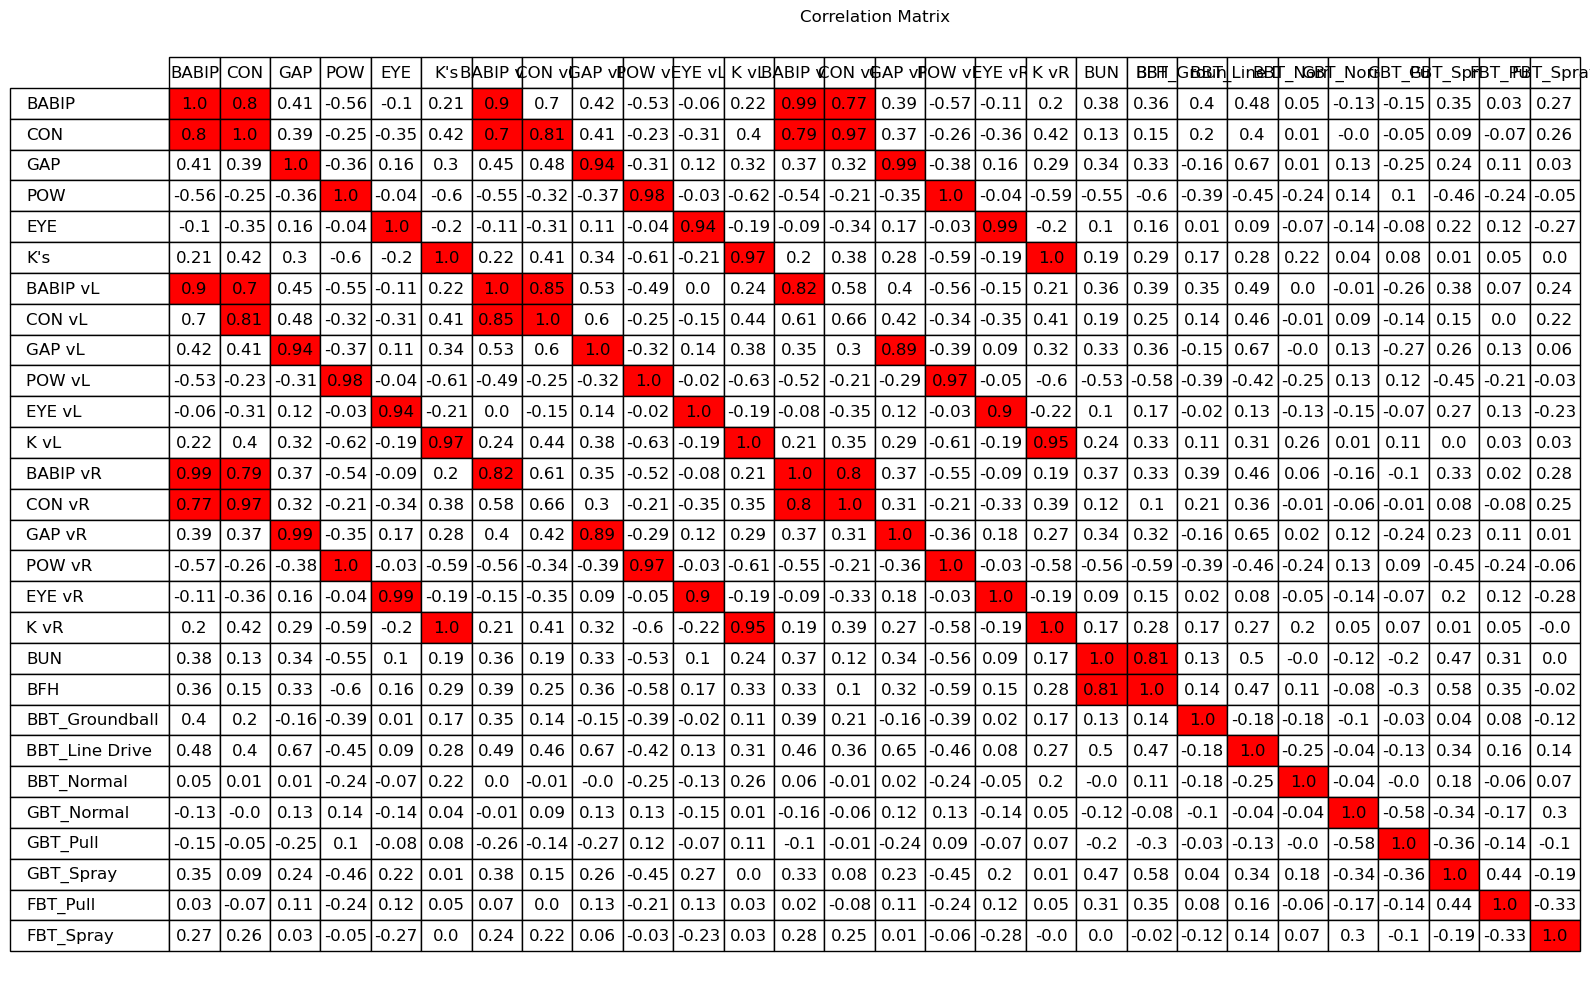

In [35]:
# Correlation matrix
correlation_matrix = df_batters_agg_model[predictors_batters].corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))

# Create a table plot
table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

# Set table properties
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Hide axis
ax.axis('off')

# Set plot title
plt.title('Correlation Matrix')

# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
def get_correlated_pairs(correlation_matrix, threshold):
    pairs = []
    n = correlation_matrix.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation)
                pairs.append(pair)

    return pairs

In [37]:
# Example usage
threshold = 0.8  # Correlation threshold
correlated_pairs = get_correlated_pairs(correlation_matrix, threshold)

# Print the correlated pairs
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

BABIP - BABIP vL: 0.9019968678816295
BABIP - BABIP vR: 0.9873375091461996
CON - CON vL: 0.8098559807683384
CON - CON vR: 0.9719717234235027
GAP - GAP vL: 0.938701031728201
GAP - GAP vR: 0.9919794984950981
POW - POW vL: 0.9811014897473901
POW - POW vR: 0.9982392272198538
EYE - EYE vL: 0.9395406830101553
EYE - EYE vR: 0.9937934746480624
K's - K vL: 0.9729368220312411
K's - K vR: 0.9973260563512408
BABIP vL - CON vL: 0.8454335928858648
BABIP vL - BABIP vR: 0.8227684857010568
GAP vL - GAP vR: 0.8885942349142706
POW vL - POW vR: 0.968275640563544
EYE vL - EYE vR: 0.8960582362356342
K vL - K vR: 0.9544116902694981
BUN - BFH: 0.8062053033748967


In [38]:
# Removal of correlated predictors
for element in ['BABIP vL', 'BABIP vR','CON','GAP vL','GAP vR','EYE vL','EYE vR','CON vL','CON vR','POW vL','POW vR','K vL','K vR']:
    predictors_batters.remove(element)

<Axes: >

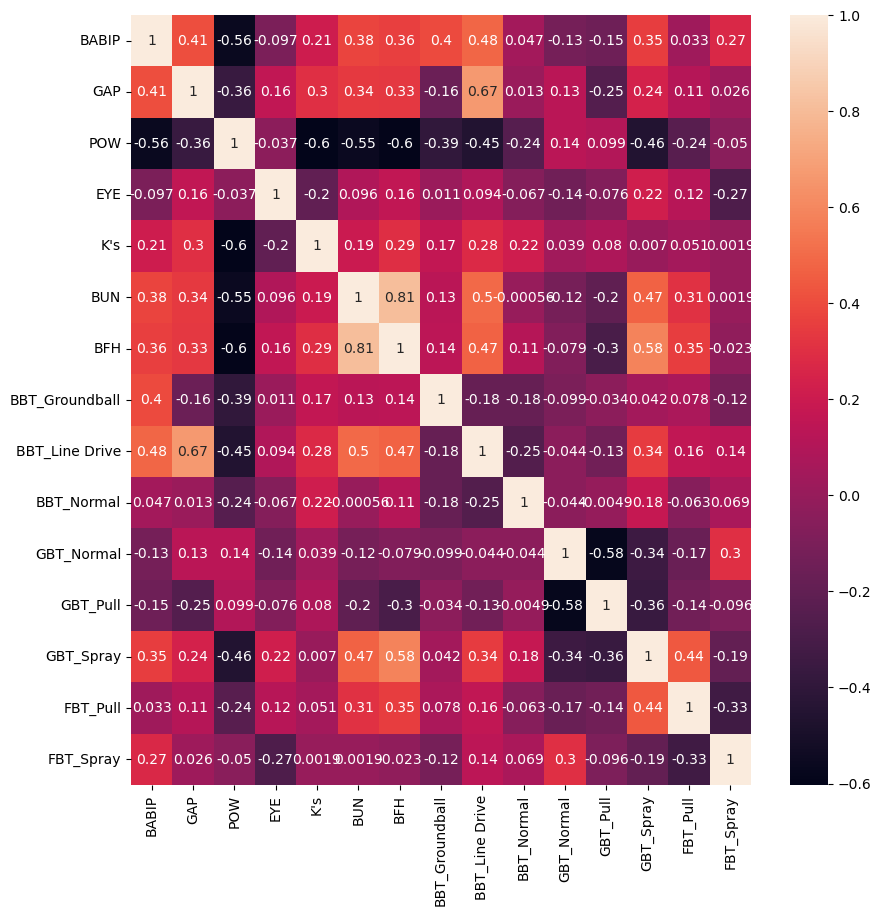

In [39]:
import seaborn as sns

plt.figure(figsize = (10, 10))
sns.heatmap(df_batters_agg_model[predictors_batters].corr(), annot = True)

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_batters_agg_model[predictors_batters].astype(float).dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)
# note: VIF under 5 is fine

           feature        VIF
0            BABIP  42.923209
1              GAP  36.909191
2              POW  15.314436
3              EYE  14.430386
4              K's  15.296281
5              BUN   6.338890
6              BFH   7.411864
7   BBT_Groundball   4.392839
8   BBT_Line Drive   6.668923
9       BBT_Normal   3.359792
10      GBT_Normal   5.352953
11        GBT_Pull   5.319718
12       GBT_Spray   4.620961
13        FBT_Pull   1.871892
14       FBT_Spray   2.255925


In [41]:
# predictors and a target variable
X = np.asarray(df_batters_agg_model[predictors_batters].values, dtype=float)
y = np.asarray(df_batters_agg_model['OPS'].values, dtype=float)

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
print("Size of train sample: " + str(len(X_train)))
print("Size of test sample: " + str(len(X_test)))

Size of train sample: 63
Size of test sample: 16


#### Backward OLS elimination

In [43]:
def backward_elimination(pred, dep, pn, significance_level=0.05):
    num_predictors = pred.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(dep, pred).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    pred = np.delete(pred, j, 1)
                    del pn[j-1] # -1 because there's an extra constant
    regressor_OLS.summary()
    return pred, pn

In [44]:
pred_names = predictors_batters.copy()

# Addition of intercept (a column of ones)
X_trn_ols = sm.add_constant(X_train)
X_tst_ols = sm.add_constant(X_test)

# Perform backward elimination
XPN = backward_elimination(X_trn_ols, y_train, pred_names, 0.1)
X_trn_ols = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y_train, X_trn_ols).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     36.86
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           1.01e-17
Time:                        14:25:26   Log-Likelihood:                 133.23
No. Observations:                  63   AIC:                            -252.5
Df Residuals:                      56   BIC:                            -237.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3826      0.032     11.915      0.0

In [45]:
# notes: Kurtosis: 3.282 -> distribution is too peaked

In [46]:
# Create a dictionary to map index labels to positions
position_dict = {label: position for position, label in enumerate(predictors_batters)}

# Retrieve positions of columns from the dictionary
column_positions = [position_dict[column] + 1 for column in pred_names]
column_positions = np.insert(column_positions, 0, 0)

# Apply results of backward elimination to test sample
X_test_be = X_tst_ols[:, column_positions]

In [47]:
from sklearn.metrics import mean_squared_log_error, r2_score

# Make predictions on the testing data
y_pred = regressor.predict(X_test_be)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The rmse score is 0.01451
The R2 score is 55.93%


In [48]:
# Sample is extremely small -> cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validation
scores = cross_val_score(LinearRegression(), X_train[:, column_positions], y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.52192556 0.63801694 0.78301026 0.86174245 0.64259104]
Mean score: 0.6894572488858747


#### Lasso

In [49]:
from sklearn.linear_model import Lasso

pred_names = predictors_batters.copy()

# Lasso regression
lasso = Lasso(alpha=0.01)  
            # Set the regularization parameter alpha
            # any real-valued number between zero and infinity; the larger the value, the more aggressive the penalization is.
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Print the coefficients
print("Lasso Coefficients:")
for feature, coef in zip(pred_names, lasso.coef_):
    if coef != 0.00000000: print(f"{feature}: {coef:.4f}") # Print out only non-zero coefs

# Print the mean squared errors
print(f"\nLasso MSE: {lasso_mse:.4f}")

train_r2 = r2_score(y_true=y_test, y_pred=lasso_predictions)
print ("The R2 score is {:.2f}%".format(train_r2*100))


# Cross-validation
scores = cross_val_score(lasso, X_train, y_train, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


## Ridge regression shrinks all regression coefficients towards zero

Lasso Coefficients:
BABIP: 0.0017
GAP: 0.0017
POW: 0.0022
EYE: 0.0007
K's: 0.0006
BUN: 0.0000
BFH: 0.0000

Lasso MSE: 0.0004
The R2 score is 70.48%

Cross-validation scores: [0.45514218 0.63279221 0.77593403 0.864133   0.67593803]
Mean score: 0.6807878907490835


#### XGBoost

In [50]:
import xgboost as xgb

# XGBRFRegressor (random forest)
xgb_model = xgb.XGBRFRegressor(objective ='reg:squarederror') # , colsample_bytree=0.2, learning_rate = 0.2, max_depth=5, alpha=5, n_estimators=40

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The rmse score is 0.01905
The R2 score is 24.68%


In [51]:
# Cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [ 0.18050866  0.26508136  0.47137389  0.68237835 -0.11037409]
Mean score: 0.2977936333047938


In [52]:
# # XGB Cross-validation 2
# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
# params = {'objective':'reg:squarederror'}
# xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'logloss',seed=42) 

# xgb_cv

In [53]:
# Best model search
# from sklearn.model_selection import GridSearchCV

# best_xgb = GridSearchCV(
#     xgb_model, param_grid={}, cv=10, verbose=0, n_jobs=-1)

# scores = cross_val_score(best_xgb, X_train, y_train, scoring='r2')
# scores

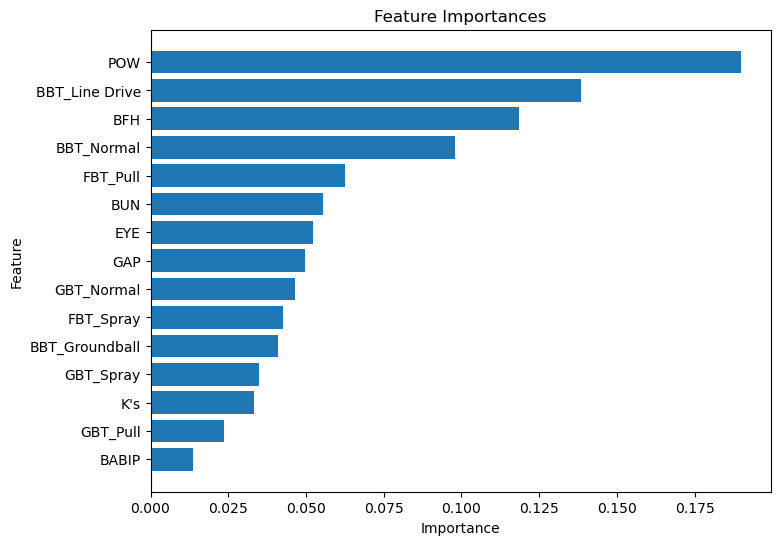

In [54]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': pred_names, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#### Prediction

In [55]:
# Predict OPS
# categorical predictors into numerical
df_batters_agg = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

df_batters_agg['ops_pred'] = lasso.predict(df_batters_agg[predictors_batters])
df_batters_agg.sort_values('ops_pred', ascending = False)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


,POS,Name,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM,BBT_Groundball,BBT_Line Drive,BBT_Normal,GBT_Normal,GBT_Pull,GBT_Spray,FBT_Pull,FBT_Spray,ops_pred
434,DH,Lou Gehrig,TRN,"6' 0""",Left,Left,65,62,70,71,84,99,45,64,58,64,61,69,39,61,74,73,92,109,47,49,38,0,0,35,35,35,38,7,1,3,0,0,0,55,0,0,0,0,0,0,18,66,48,133.333333,133.333333,72.0,508.333333,125.0,100.0,8.333333,0.0,16.666667,41.666667,33.333333,91.666667,15.3,0.0,0.0,0.0,0.0,0.0,125.0,20.8,8.333333,25.0,183.333333,0.246,0.361,0.361,8.6,5.0,0.115,0.347,0.722,95.0,0.295,-3.666667,66.666667,101.0,0.833333,0.0,4.94,0.0,0.0,0.0,0.833333,0.0,-15.833333,-15.833333,91.666667,91.666667,591.666667,66.666667,525.0,0.0,33.333333,0.0,1.0,6.33,0.4,1.133,0.0,0.0,0.0,101.0,0.0,0.0,0.0,100.0,79.207921,79.207921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.80198,0.0,29.70297,0.0,0.0,100.0,72,101.0,0,0,0,0,1,0,0,0,0.835201
47,1B,Lou Gehrig,TRN,"6' 0""",Left,Left,65,62,70,71,84,99,45,64,58,64,61,69,39,61,74,73,92,109,47,49,38,0,0,35,35,35,38,7,1,3,55,0,0,55,0,0,0,0,0,0,18,66,48,156.179598,134.386781,45.810755,491.64541,140.278562,78.665433,21.521931,2.370257,37.720942,97.64103,95.406217,98.927741,17.692451,1.814939,2.708865,0.0,6.528364,0.189621,118.255491,19.239297,13.056728,61.613129,279.703831,0.291815,0.416178,0.555749,9.132472,9.435057,0.264031,0.426006,0.971882,154.880041,0.311242,4.006546,106.824082,155.009307,40.209034,4.476399,4.49758,0.135443,1.259622,1.034126,40.209034,-0.413102,-0.089393,-0.502494,59.242872,56.032868,422.312016,23.675478,395.683875,2.952663,51.265266,0.0,0.688839,5.292854,0.009617,0.577265,0.0,0.0,0.0,38.835264,0.0,0.0,0.0,56.335367,170.982263,162.461643,35.884178,38.844449,34.661434,14.477766,22.915649,10.30598,11.83909,24.716164,10.612128,9.462254,15.283161,7.520334,19.132748,0.0,0.0,100.0,967,849.5,0,0,0,0,1,0,0,0,0.835201
430,DH,Jimmy Ryan,TRN,"5' 9""",Right,Left,59,84,84,83,67,63,52,85,86,84,68,64,52,84,84,82,66,62,52,6,2,0,0,28,23,25,24,73,56,80,0,60,0,0,0,0,0,0,59,0,88,91,89,130.426647,130.426647,54.162162,531.025449,157.709581,92.065868,47.979042,5.913174,11.751497,95.05988,77.956587,56.399701,10.126014,0.0,0.0,0.0,10.291916,2.282934,95.396707,17.570608,7.672156,65.643713,252.769461,0.256571,0.328791,0.398828,8.303041,5.165878,0.14177,0.327703,0.727618,88.932432,0.302527,0.159057,79.827844,87.574324,11.115269,0.56512,3.660338,21.669162,19.161677,52.47973,11.115269,-3.023952,-7.402695,-11.017964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,100.0,296,0.0,0,1,0,1,0,0,0,1,0.834388
645,RP,Jimmy Ryan,TRN,"5' 9""",Right,Left,59,84,84,83,67,63,52,85,86,84,68,64,52,84,84,82,66,62,52,6,2,0,0,28,23,25,24,73,56,80,60,60,0,0,0,0,0,0,59,0,88,91,89,136.272133,130.973705,57.054109,527.631096,161.030339,99.360288,38.683356,2.120445,20.866251,89.810234,87.2657,63.361039,10.155487,4.702556,4.643506,0.0,4.364359,0.0,113.478693,19.447218,11.015577,61.670052,266.553338,0.290571,0.365089,0.470194,9.868657,6.932568,0.179538,0.369666,0.83523,119.07708,0.339558,2.627419,90.926822,117.449209,22.739758,3.483971,3.758412,25.28966,14.472707,46.86391,22.739758,-0.198087,0.477234,0.433752,72.186384,67.231522,250.191019,4.906548,239.48143,5.80304,2.700212,0.0,0.623487,2.263946,-0.136192,0.629895,0.0,0.0,0.0,57.914548,0.0,0.0,0.0,62.806738,523.921252,513.478876,47.242675,94.447234,78.719452,24.061511,62.783418

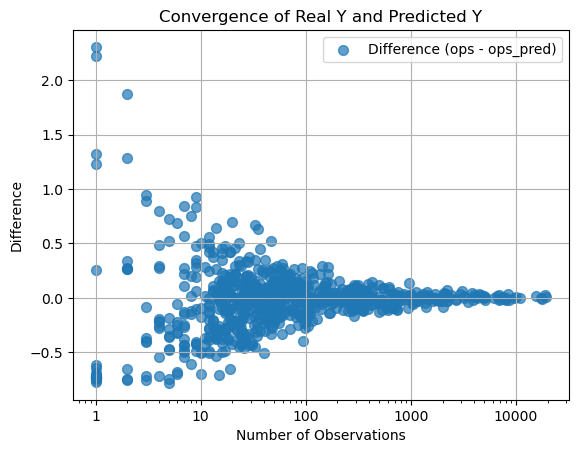

In [56]:
from matplotlib.ticker import ScalarFormatter

def plot_convergence(observations, ops, ops_pred):
    differences = np.array(ops) - np.array(ops_pred)

    plt.scatter(observations, differences, s=50, alpha=0.7, label='Difference (ops - ops_pred)')

    plt.xlabel('Number of Observations')
    plt.ylabel('Difference')
    plt.title('Convergence of Real Y and Predicted Y')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set logarithmic scale for the x-axis
    #plt.xlim(1, 10000)  # Set x-axis limits
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.show()


plot_convergence( df_batters_agg['PA_WM'], df_batters_agg['OPS'], df_batters_agg['ops_pred'])


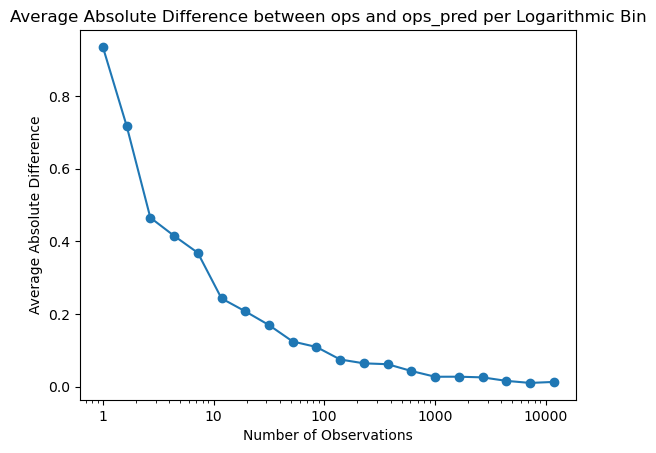

In [57]:
observations = df_batters_agg['PA_WM']
ops = df_batters_agg['OPS']
ops_pred = df_batters_agg['ops_pred']

# Calculate the absolute differences between ops and ops_pred
differences = np.abs(np.array(ops) - np.array(ops_pred))

# Calculate the logarithmic bins
log_bins = np.logspace(np.log10(1), np.log10(max(observations)),num=21)

# Calculate the bin indices for each observation
bin_indices = np.digitize(observations, log_bins)

# Calculate the average absolute differences for each bin
bin_averages = [np.mean(differences[bin_indices == i]) for i in range(1, len(log_bins))]


fig, ax = plt.subplots()
ax.plot(log_bins[:-1], bin_averages, 'o-')

ax.set_xscale('log')
ax.set_xlabel('Number of Observations')
ax.set_ylabel('Average Absolute Difference')
ax.set_title('Average Absolute Difference between ops and ops_pred per Logarithmic Bin')

# Set full number format for x-axis ticks
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()